Всего комментариев: 2373

Первые 5 записей:
        id  rating                                       comment  \
0  2945792       5                                       спасибо   
1  3234340       5                                      спасибо!   
2  3380332       5                                      Отлично    
3  3381812       5  Благодарю за оперативное решение проблемы !    
4  3461991       5         Прекрасный специалист! Побольше таких   

   Нравится скорость отработки заявок  Нравится качество выполнения заявки  \
0                                 NaN                                  NaN   
1                                 NaN                                  NaN   
2                                 NaN                                  NaN   
3                                 NaN                                  NaN   
4                                 NaN                                  NaN   

   Нравится качество работы сотрудников  Понравилось выполнение заявки  \
0   

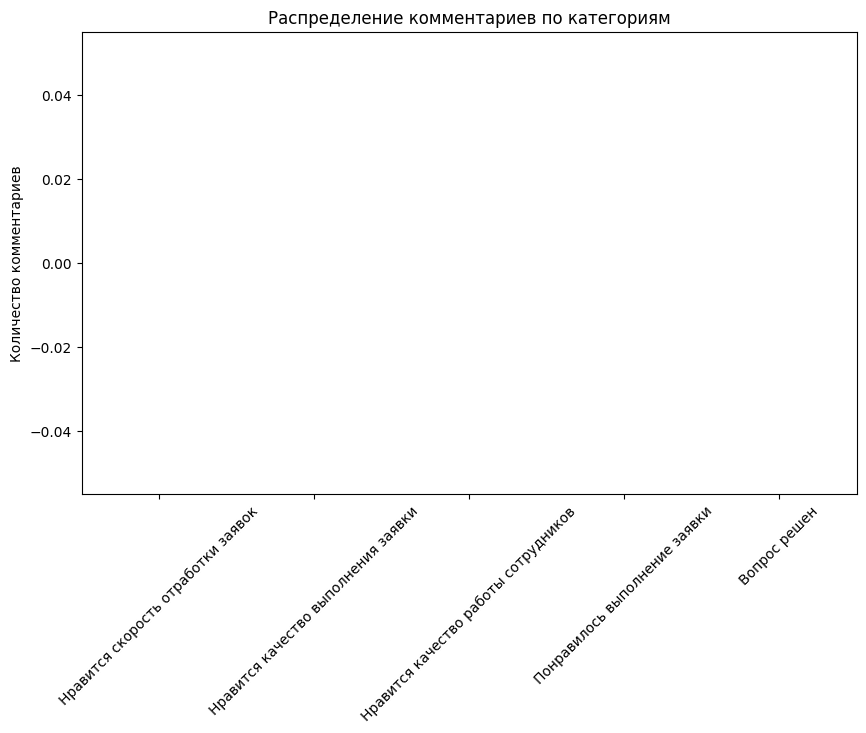

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

data = pd.read_csv('comments.csv')

# Предварительный анализ данных
print(f"Всего комментариев: {len(data)}")
print("\nПервые 5 записей:")
print(data.head())

print("\nИнформация о датасете:")
print(data.info())

print("\nСтатистика по классам:")
class_columns = ['Нравится скорость отработки заявок', 
                'Нравится качество выполнения заявки', 
                'Нравится качество работы сотрудников', 
                'Понравилось выполнение заявки', 
                'Вопрос решен']
print(data[class_columns].sum())

# Визуализация распределения классов
plt.figure(figsize=(10, 6))
data[class_columns].sum().plot(kind='bar')
plt.title('Распределение комментариев по категориям')
plt.ylabel('Количество комментариев')
plt.xticks(rotation=45)
plt.show()

In [2]:
# Генерация конфигурации для Label Studio
label_config = """
<View>
  <Header value="Выберите категории, которые относятся к комментарию:"/>
  <Text name="text" value="$text"/>
  <Choices name="sentiment" toName="text" choice="multiple" showInLine="true">
    <Choice value="Нравится скорость отработки заявок"/>
    <Choice value="Нравится качество выполнения заявки"/>
    <Choice value="Нравится качество работы сотрудников"/>
    <Choice value="Понравилось выполнение заявки"/>
    <Choice value="Вопрос решен"/>
  </Choices>
</View>
"""

# Сохранение конфигурации в файл
with open('label_config.xml', 'w', encoding='utf-8') as f:
    f.write(label_config)

# Подготовка данных для импорта в Label Studio
label_studio_data = []
for idx, row in data.iterrows():
    label_studio_data.append({
        'data': {
            'text': row['comment']  # предполагаем, что текст комментария в колонке 'comment_text'
        },
        'predictions': [{
            'result': [],
            'score': 0
        }]
    })

# Сохранение данных в JSON для импорта в Label Studio
import json
with open('comments_for_labeling.json', 'w', encoding='utf-8') as f:
    json.dump(label_studio_data, f, ensure_ascii=False, indent=2)

print("Файлы для Label Studio подготовлены:")
print("- label_config.xml - конфигурация интерфейса разметки")
print("- comments_for_labeling.json - данные для разметки")

Файлы для Label Studio подготовлены:
- label_config.xml - конфигурация интерфейса разметки
- comments_for_labeling.json - данные для разметки


In [3]:
import json
import pandas as pd

def process_label_studio_export(export_file):
    with open(export_file, 'r', encoding='utf-8') as f:
        labeled_data = json.load(f)
    
    processed_data = []
    
    for item in labeled_data:
        # Проверяем, есть ли разметка для этого элемента
        if 'annotations' not in item or len(item['annotations']) == 0:
            continue
            
        text = item['data']['text']
        annotations = item['annotations'][0]
        
        # Инициализируем все категории как 0
        row = {
            'text': text,
            'Нравится скорость отработки заявок': 0,
            'Нравится качество выполнения заявки': 0,
            'Нравится качество работы сотрудников': 0,
            'Понравилось выполнение заявки': 0,
            'Вопрос решен': 0
        }
        
        # Обрабатываем все результаты аннотации
        for result in annotations['result']:
            if 'value' in result and 'choices' in result['value']:
                for choice in result['value']['choices']:
                    if choice in row:
                        row[choice] = 1
        
        processed_data.append(row)
    
    return pd.DataFrame(processed_data)

# Использование функции
labeled_df = process_label_studio_export('exported_labels.json')

# Сохранение в CSV
labeled_df.to_csv('labeled_comments_processed.csv', index=False, encoding='utf-8')

print(f"Успешно обработано {len(labeled_df)} комментариев")
print("\nРаспределение по категориям:")
print(labeled_df.drop(columns='text').sum())

Успешно обработано 150 комментариев

Распределение по категориям:
Нравится скорость отработки заявок       29
Нравится качество выполнения заявки      16
Нравится качество работы сотрудников     29
Понравилось выполнение заявки           106
Вопрос решен                             13
dtype: int64


In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
import nltk
import warnings
import joblib

# Настройки
warnings.filterwarnings('ignore')
nltk.download('stopwords')

# Подготовка стоп-слов
russian_stop_words = stopwords.words('russian')
custom_stop_words = ['спасибо', 'благодарю', 'заявк', 'управляющ', 'компани', 'сдел', 'работ']
all_stop_words = russian_stop_words + custom_stop_words

# Загрузка данных
try:
    labeled_data = pd.read_csv('labeled_comments_processed.csv')
    print(f"Успешно загружено {len(labeled_data)} комментариев")
    
    class_columns = ['Нравится скорость отработки заявок', 
                   'Нравится качество выполнения заявки', 
                   'Нравится качество работы сотрудников', 
                   'Понравилось выполнение заявки', 
                   'Вопрос решен']
    
    # Проверка распределения классов
    class_distribution = labeled_data[class_columns].sum()
    print("\nРаспределение по классам:")
    print(class_distribution)
    
    # Фильтрация классов с недостаточным количеством примеров
    valid_columns = [col for col in class_columns if class_distribution[col] >= 2]
    if len(valid_columns) < len(class_columns):
        print(f"\nУдалены классы с недостаточным количеством примеров: {set(class_columns) - set(valid_columns)}")
        class_columns = valid_columns
    
    if not class_columns:
        raise ValueError("Нет классов с достаточным количеством примеров для обучения!")
        
except Exception as e:
    print(f"Ошибка загрузки данных: {e}")
    raise

# Подготовка данных
X = labeled_data['text']
y = labeled_data[class_columns]

# Разделение данных
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
except ValueError:
    print("\nПредупреждение: невозможно использовать стратификацию. Использую обычное разделение.")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

# Создание и обучение пайплайна
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        stop_words=all_stop_words,
        ngram_range=(1, 2),
        min_df=2
    )),
    ('clf', MultiOutputClassifier(
        RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced',
            random_state=42
        ),
        n_jobs=-1
    ))
])

print("\nОбучение модели...")
pipeline.fit(X_train, y_train)

# Оценка модели
y_pred = pipeline.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_columns))

# Вычисление ROC-AUC
print("\nROC-AUC scores:")
y_pred_proba = pipeline.predict_proba(X_test)
for i, class_name in enumerate(class_columns):
    try:
        if len(np.unique(y_test[class_name])) >= 2:
            auc = roc_auc_score(y_test[class_name], y_pred_proba[i][:, 1])
            print(f"{class_name}: {auc:.4f}")
    except Exception as e:
        print(f"{class_name}: ошибка вычисления - {str(e)}")

# Сохранение модели
joblib.dump(pipeline, 'comment_classifier.joblib')
print("\nМодель успешно сохранена в 'comment_classifier.joblib'")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Silv3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Успешно загружено 150 комментариев

Распределение по классам:
Нравится скорость отработки заявок       29
Нравится качество выполнения заявки      16
Нравится качество работы сотрудников     29
Понравилось выполнение заявки           106
Вопрос решен                             13
dtype: int64

Предупреждение: невозможно использовать стратификацию. Использую обычное разделение.

Обучение модели...

Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок       0.50      0.67      0.57         3
 Нравится качество выполнения заявки       0.00      0.00      0.00         2
Нравится качество работы сотрудников       0.75      0.50      0.60         6
       Понравилось выполнение заявки       0.81      0.88      0.84        24
                        Вопрос решен       0.67      0.67      0.67         3

                           micro avg       0.72      0.74      0.73        38
                           

In [ ]:
# Анализ важности признаков
feature_importances = []
for i, class_name in enumerate(class_columns):
    importances = pipeline.named_steps['clf'].estimators_[i].feature_importances_
    feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()
    feature_importances.append(pd.DataFrame({
        'feature': feature_names,
        'importance': importances,
        'class': class_name
    }))

# Объединение всех важностей
all_importances = pd.concat(feature_importances)

# Топ-10 важных слов для каждой категории
for class_name in class_columns:
    print(f"\nTop 10 features for {class_name}:")
    print(all_importances[all_importances['class'] == class_name]
          .sort_values('importance', ascending=False)
          .head(10)[['feature', 'importance']])


Top 10 features for Нравится скорость отработки заявок:
             feature  importance
1             быстро    0.208299
21     оперативность    0.168212
18        оперативно    0.138964
32            работа    0.051101
34            работу    0.046545
30            пришли    0.039224
29  очень оперативно    0.033916
28             очень    0.026260
13            мастер    0.025814
0            большое    0.022185

Top 10 features for Нравится качество выполнения заявки:
        feature  importance
13       мастер    0.121072
10       заявки    0.089915
7         дверь    0.081972
9   закрывается    0.081736
33     работает    0.077958
18   оперативно    0.069922
1        быстро    0.048934
42        чётко    0.035594
32       работа    0.027268
12     компании    0.027105

Top 10 features for Нравится качество работы сотрудников:
          feature  importance
13         мастер    0.216238
41        татьяна    0.112871
0         большое    0.075240
1          быстро    0.074382
14   

In [6]:
# Загрузка сохраненной модели
model = joblib.load('comment_classifier.joblib')

# Пример новых отзывов для классификации
new_comments = [
    "Мастер пришел быстро и все качественно починил",
    "Спасибо за решение проблемы",
    "Работа выполнена неаккуратно, пришлось переделывать",
    "Сотрудники вежливые и профессиональные"
]

# Предсказание для новых отзывов
predictions = model.predict(new_comments)
pred_proba = model.predict_proba(new_comments)

# Создаем DataFrame с результатами
results_df = pd.DataFrame({
    'Комментарий': new_comments,
    **{class_name: predictions[:, i] for i, class_name in enumerate(class_columns)},
    **{f'Вероятность_{class_name}': pred_proba[i][:, 1] for i, class_name in enumerate(class_columns)}
})

# Выводим красивые результаты
print("\nАвтоматическая классификация новых отзывов:")
display(results_df.style.background_gradient(cmap='Blues', subset=class_columns))


Автоматическая классификация новых отзывов:


,Комментарий,Нравится скорость отработки заявок,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Понравилось выполнение заявки,Вопрос решен,Вероятность_Нравится скорость отработки заявок,Вероятность_Нравится качество выполнения заявки,Вероятность_Нравится качество работы сотрудников,Вероятность_Понравилось выполнение заявки,Вероятность_Вопрос решен
0,Мастер пришел быстро и все качественно починил,1,0,1,1,0,0.704053,0.370309,0.939268,0.547476,0.000000
1,Спасибо за решение проблемы,0,0,0,0,0,0.273188,0.339073,0.365806,0.422729,0.469309
2,"Работа выполнена неаккуратно, пришлось переделывать",1,0,0,0,0,0.628051,0.126486,0.117237,0.339701,0.138656
3,Сотрудники вежливые и профессиональные,0,0,0,1,0,0.133868,0.216608,0.221498,0.730333,0.474209


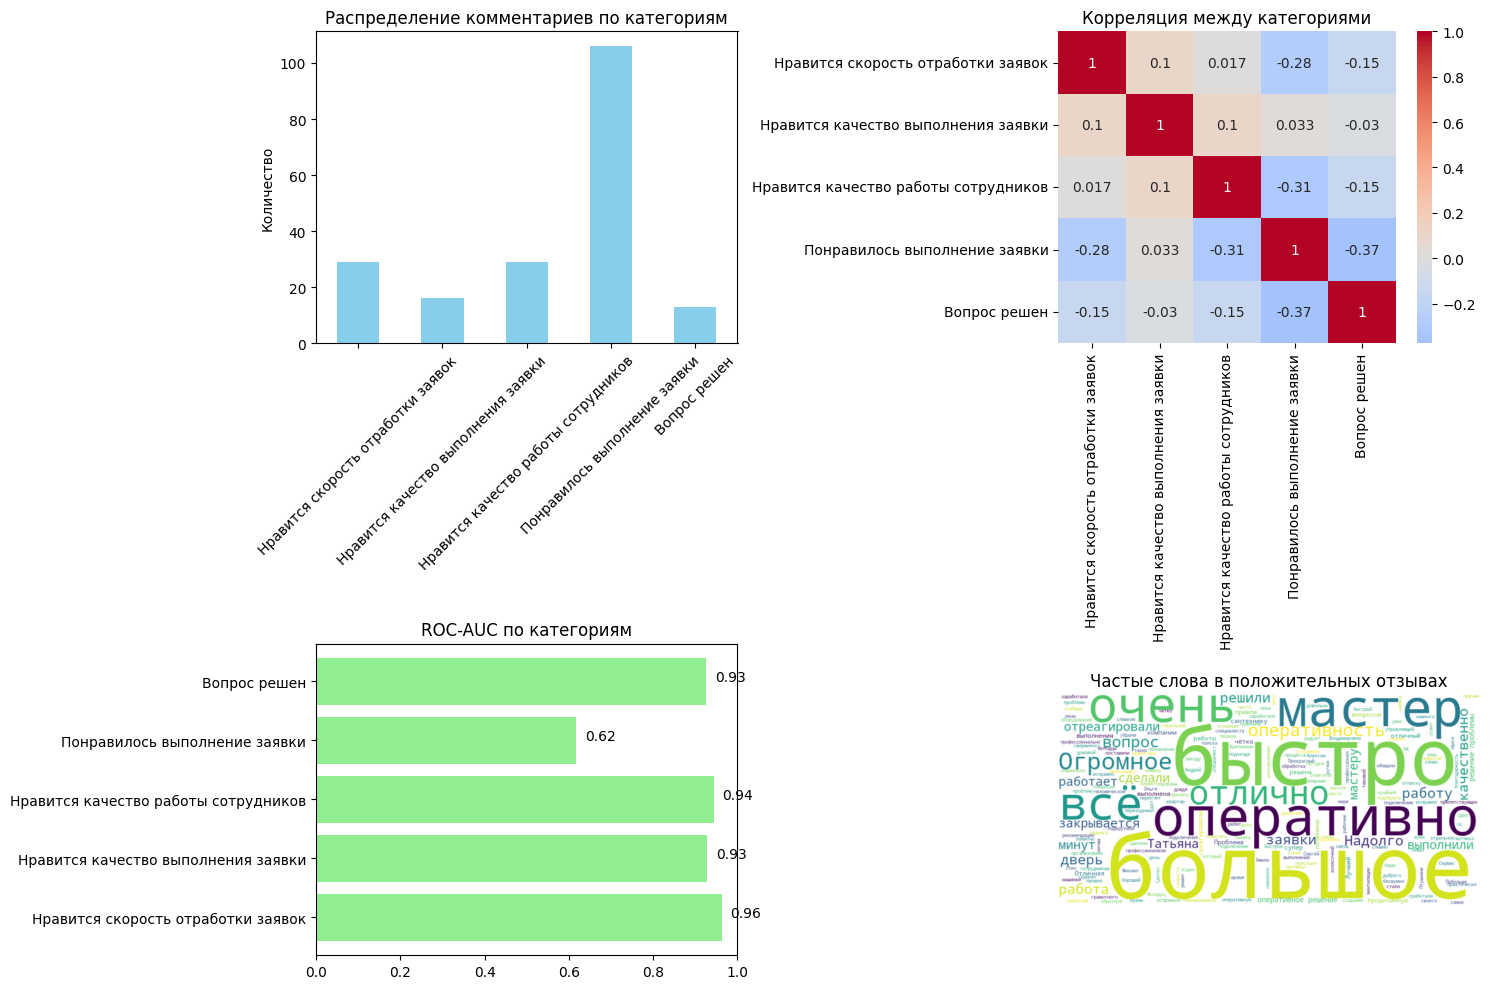

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import roc_auc_score
import numpy as np

plt.figure(figsize=(15, 10))

# 1. Распределение классов
plt.subplot(2, 2, 1)
y.sum().plot(kind='bar', color='skyblue')
plt.title('Распределение комментариев по категориям')
plt.ylabel('Количество')
plt.xticks(rotation=45)

# 2. Матрица корреляций между категориями
plt.subplot(2, 2, 2)
sns.heatmap(y.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Корреляция между категориями')

# 3. ROC-AUC для каждой категории (с обработкой ошибок)
plt.subplot(2, 2, 3)
auc_scores = []
for i, col in enumerate(class_columns):
    try:
        # Проверяем, что в тестовых данных есть оба класса
        if len(np.unique(y_test[col])) == 2:
            auc = roc_auc_score(y_test[col], model.predict_proba(X_test)[i][:, 1])
            auc_scores.append(auc)
        else:
            auc_scores.append(np.nan)
    except Exception as e:
        print(f"Ошибка расчета ROC-AUC для '{col}': {str(e)}")
        auc_scores.append(np.nan)

valid_auc = [x for x in auc_scores if not np.isnan(x)]
valid_labels = [class_columns[i] for i, x in enumerate(auc_scores) if not np.isnan(x)]

if len(valid_auc) > 0:
    plt.barh(valid_labels, valid_auc, color='lightgreen')
    plt.title('ROC-AUC по категориям')
    plt.xlim(0, 1)
    for i, v in enumerate(valid_auc):
        plt.text(v + 0.02, i, f"{v:.2f}", color='black')
else:
    plt.text(0.5, 0.5, 'Не удалось рассчитать ROC-AUC\nдля каких-либо категорий', 
             ha='center', va='center')
    plt.title('ROC-AUC недоступен')

# 4. Облако слов для положительных отзывов
plt.subplot(2, 2, 4)
positive_mask = (y.sum(axis=1) > 0)
if sum(positive_mask) > 0:
    all_positive_text = ' '.join(X[positive_mask])
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white',
                         stopwords=all_stop_words).generate(all_positive_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Частые слова в положительных отзывах')
else:
    plt.text(0.5, 0.5, 'Нет положительных отзывов\nдля анализа', 
             ha='center', va='center')
    plt.title('Облако слов недоступно')
plt.axis('off')

plt.tight_layout()
plt.show()

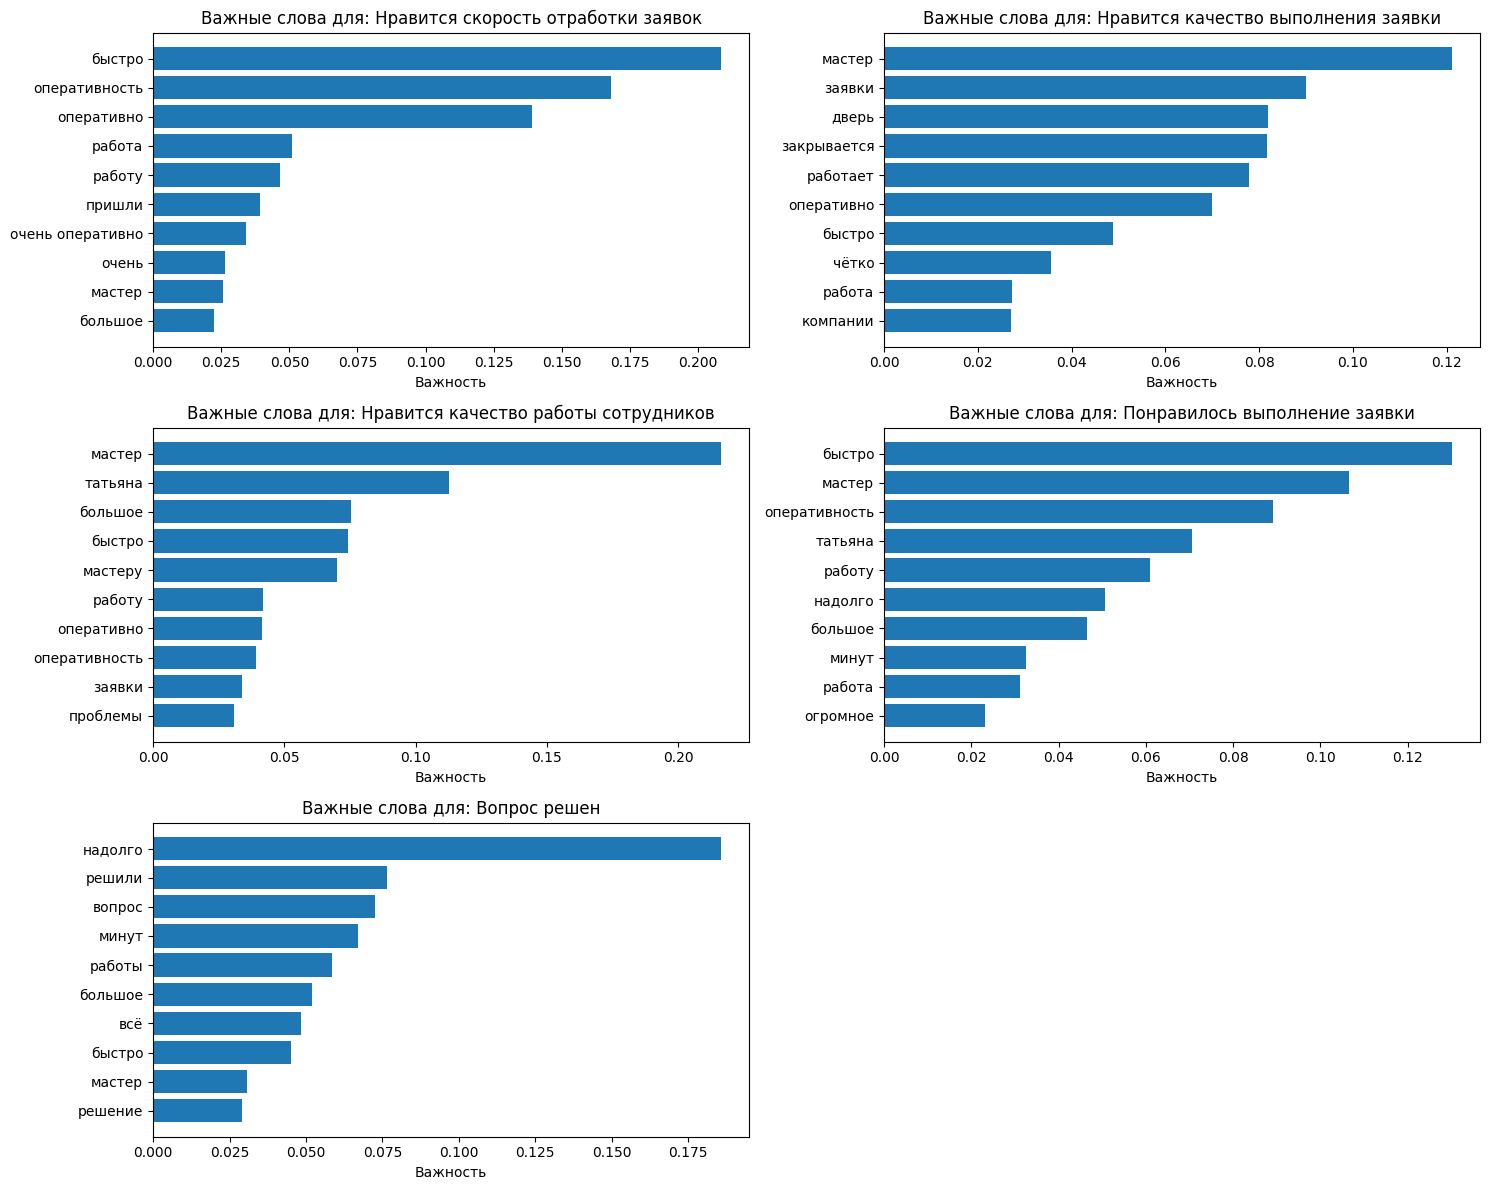

In [8]:
# Получаем важные слова для каждой категории
feature_names = model.named_steps['tfidf'].get_feature_names_out()

plt.figure(figsize=(15, 12))
for i, category in enumerate(class_columns):
    plt.subplot(3, 2, i+1)
    importances = model.named_steps['clf'].estimators_[i].feature_importances_
    top_idx = np.argsort(importances)[-10:]
    plt.barh(feature_names[top_idx], importances[top_idx])
    plt.title(f'Важные слова для: {category}')
    plt.xlabel('Важность')

plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import precision_recall_fscore_support

# Создаем отчет
report = classification_report(y_test, y_pred, 
                             target_names=class_columns,
                             output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Сохраняем все результаты в один файл
with pd.ExcelWriter('classification_report.xlsx') as writer:
    results_df.to_excel(writer, sheet_name='Новые предсказания')
    report_df.to_excel(writer, sheet_name='Метрики модели')
    y.sum().to_frame('Количество').to_excel(writer, sheet_name='Распределение классов')
    
print("Полный отчет сохранен в файл 'classification_report.xlsx'")

Полный отчет сохранен в файл 'classification_report.xlsx'


In [10]:
def classify_new_comment(comment):
    """Функция для классификации одного комментария"""
    proba = model.predict_proba([comment])
    result = {
        'Комментарий': comment,
        **{class_col: model.predict([comment])[0][i] 
          for i, class_col in enumerate(class_columns)},
        **{f'Вероятность_{class_col}': float(proba[i][0][1]) 
          for i, class_col in enumerate(class_columns)}
    }
    return result

# Пример использования
sample_comment = "Быстро ответили на заявку и профессионально устранили проблему"
classification_result = classify_new_comment(sample_comment)
print("\nРезультат классификации для комментария:")
print(f"'{sample_comment}'")
for k, v in classification_result.items():
    if k.startswith('Вероятность') and v > 0.5:
        print(f"{k.replace('Вероятность_', '')}: {v:.2f}")


Результат классификации для комментария:
'Быстро ответили на заявку и профессионально устранили проблему'
Нравится скорость отработки заявок: 0.81
